In [2]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [3]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 転置畳み込みの例

In [4]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))


入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


# Generatorの実装

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

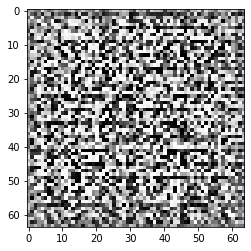

In [6]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminatorの実装

In [7]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [8]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.5014]]]], grad_fn=<SigmoidBackward>)


# 6.2へ


# GANの損失関数

In [9]:
# Dの誤差関数のイメージ実装
# maximize log(D(x)) + log(1 - D(G(z)))


# ※ xが未定義なので動作はエラーになります
#---------------


# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 真の画像を判定
d_out_real = D(x)

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake


NameError: name 'x' is not defined

In [10]:
# Gの誤差関数のイメージ実装
# maximize log(D(G(z)))


# ※ xが未定義なので動作はエラーになります
#---------------


# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
g_loss = criterion(d_out_fake.view(-1), label_real)


# DataLoaderの作成

In [11]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(1, 5000):
        if img_idx < 10:
         img_idx = '0000'+ str(img_idx)
        elif img_idx < 100:
         img_idx = '000'+ str(img_idx)
        elif img_idx < 1000:
         img_idx = '00'+ str(img_idx)
        elif img_idx < 10000:
         img_idx = '0'+ str(img_idx)
        img_path = "./data/re_distmap/" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [12]:
def make_datapath_list2():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(1, 1000):
        if img_idx < 10:
         img_idx = '0000'+ str(img_idx)
        elif img_idx < 100:
         img_idx = '000'+ str(img_idx)
        elif img_idx < 1000:
         img_idx = '00'+ str(img_idx)
        elif img_idx < 10000:
         img_idx = '0'+ str(img_idx)
        img_path = "./data/distmap2/" + str(img_idx)+'.png'
        train_img_list.append(img_path)

    return train_img_list

In [17]:
def make_datapath_list3():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    number = "/data/taiheiyamaguchi/scop/typescript"
    with open(number) as f:
        llist = f.read().splitlines()
    for i in range(9,80523):
        ll = list(llist[i].split())
        for j in range(len(ll)):
            for k in range(13, len(ll[j])):
                if ll[j][k]=='.':
                    img_path = "/data/taiheiyamaguchi/scop/distmap64/" + ll[j][13: k+4]
                    train_img_list.append(img_path)

    return train_img_list

In [18]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [31]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = np.load(img_path)

        # 画像の前処理
        img_transformed = self.transform(img)
        img_transformed = img_transformed.to(torch.float32)

        return img_transformed


In [32]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list3()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])



torch.Size([64, 1, 64, 64])


# 学習させる

In [33]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [34]:
# モデルを学習させる関数を作成
box = []

def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        b = [epoch_d_loss, epoch_g_loss]
        box.append(b)

    return G, D


In [35]:
# 学習・検証を実行する
# 6分ほどかかる
num_epochs = 50
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/50
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:18.5049 ||Epoch_G_Loss:6894.9979
timer:  19775.2338 sec.
-------------
Epoch 1/50
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7635.3609
timer:  6102.9087 sec.
-------------
Epoch 2/50
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7761.8876
timer:  833.8451 sec.
-------------
Epoch 3/50
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7843.6329
timer:  714.5446 sec.
-------------
Epoch 4/50
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7889.8268
timer:  713.7437 sec.
-------------
Epoch 5/50
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7930.9562
timer:  703.3233 sec.
-------------
Epoch 6/50
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:7964.4118
timer:  728.3761 sec.
--------

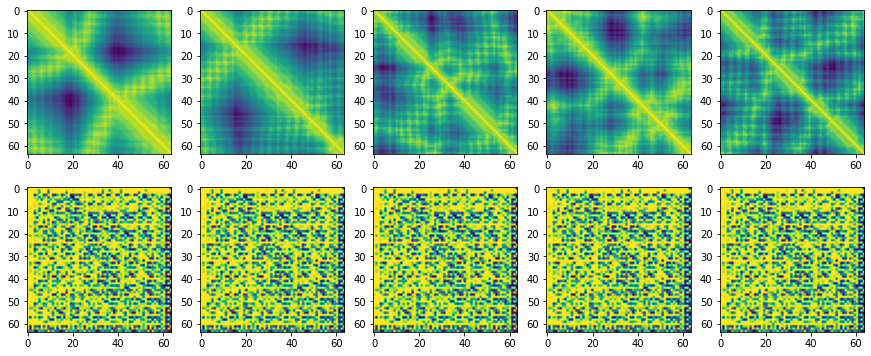

In [38]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(-imges[i][0].cpu().detach().numpy())

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy())

以上

(64, 64)
[[ 0.8899381   0.693192    0.4306129  ... -0.558602   -0.4657451
  -0.42253622]
 [ 0.7476677   0.70006686  0.59239864 ... -0.5152263  -0.47144565
  -0.6230029 ]
 [ 0.45493826  0.54964006  0.8263668  ... -0.5478772  -0.5333148
  -0.63207304]
 ...
 [ 0.35206658  0.31329688  0.47574547 ...  0.6534517   0.60195756
   0.36893207]
 [ 0.48829904  0.40036836  0.5815458  ...  0.4576098   0.68667907
   0.68102926]
 [ 0.32051286  0.5285817   0.57178295 ...  0.40865135  0.61714566
   0.743941  ]]


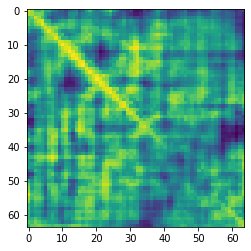

In [26]:
plt.imshow(fake_images[0][0].cpu().detach().numpy())
im = fake_images[0][0].cpu().detach().numpy()
print(im.shape)
print(im)
#plt.savefig('/data/taiheiyamaguchi/scop/gan/generated/sample.jpg')


In [36]:
dist = []
bet = (22 - 2.3) / 2
print(bet)

for i in range(64):
    dist.append([])
    for j in range(64):
        im[i][j] = round(im[i][j],5)
        dis = (im[i][j] + 1) * bet + 2.3
        dist[i].append(dis)
dist = np.array(dist)
print(dist.shape)
print(dist)

9.85
(64, 64)
[[22.   22.   12.15 ...  2.3  12.15 12.15]
 [22.   22.   22.   ...  2.3  12.15  2.3 ]
 [12.15 22.   22.   ...  2.3   2.3   2.3 ]
 ...
 [12.15 12.15 12.15 ... 22.   22.   12.15]
 [12.15 12.15 22.   ... 12.15 22.   22.  ]
 [12.15 22.   22.   ... 12.15 22.   22.  ]]


In [78]:
print(len(box))
y1 = []
y2 = []
epoch = 350
for i in range(epoch):
    y1.append(box[i][0])
    y2.append(box[i][1])
x = list(range(epoch))

350


In [79]:
print(len(box))

350


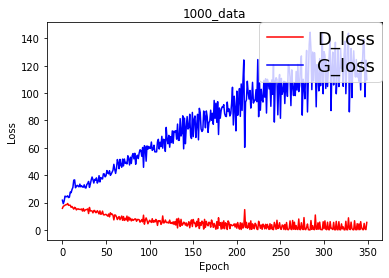

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(x, y1, "red", label="D_loss")
plt.plot(x, y2, "blue", label="G_loss")
plt.title("1000_data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)
plt.savefig('/data/taiheiyamaguchi/scop/gan/result/1000_loss.png')